## Seasonality Analysis and Forecasting with Timeseries

In this project, we use time series model that takes into account past trend and seasonality to forecast into the future. In other words, the model uses the previous n observations to forecast the n+1 values into the future. <br> Summary: <br> - We will be conducting EDA on the dataset to gain understand how the sales data varies over time. <br> - Then, we decompose the data set into trend and seasonality components. <br> -  Next, we will build a predict ARIMA (Auto Regressive Integrated Moving Average) model to forecast sales in the future.

### About the dataset
The data set used in the project contains monthly champagne sales values of Perrin Freres brand from January 1964 to September 1972. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMAResults
from pmdarima import auto_arima

In [ ]:
file_path = r"C:\Users\KateTran\Documents\Kate\Timeseries\Perrin Freres monthly champagne sales millions.xlsx"
sales = pd.read_excel(file_path, parse_dates = ['Month'])
sales.head()

,Month,Sales in millions
0,1964-01-01 00:00:00,2815.0
1,1964-02-01 00:00:00,2672.0
2,1964-03-01 00:00:00,2755.0
3,1964-04-01 00:00:00,2721.0
4,1964-05-01 00:00:00,2946.0


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              106 non-null    object 
 1   Sales in millions  105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [ ]:
sales.isnull().sum()

Month                1
Sales in millions    2
dtype: int64

In [ ]:
sales.dropna(subset=['Month', 'Sales in millions'], inplace=True)

In [ ]:

sales['Month'] = pd.to_datetime(sales.Month)
sales.set_index('Month', inplace = True)
sales.index.freq='MS'
sales.columns = ['Actual']
sales.head(10)

,Actual
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0
1964-07-01,2282.0
1964-08-01,2212.0
1964-09-01,2922.0


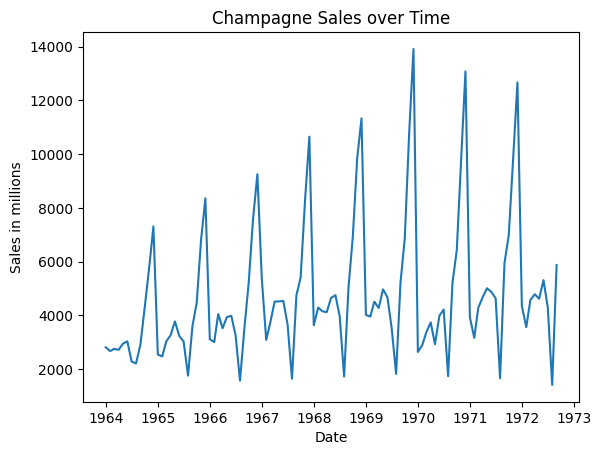

In [ ]:
plt.plot(sales)
plt.xlabel('Date')
plt.ylabel('Sales in millions')
plt.title('Champagne Sales over Time')
plt.show()

Key observations: <br> - The data is showing an increasing trend over time. <br> - The regular peaks and troughs suggesing seasonality.

The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. With this we will be able to see the trend, seasonal, and residual components of our data.

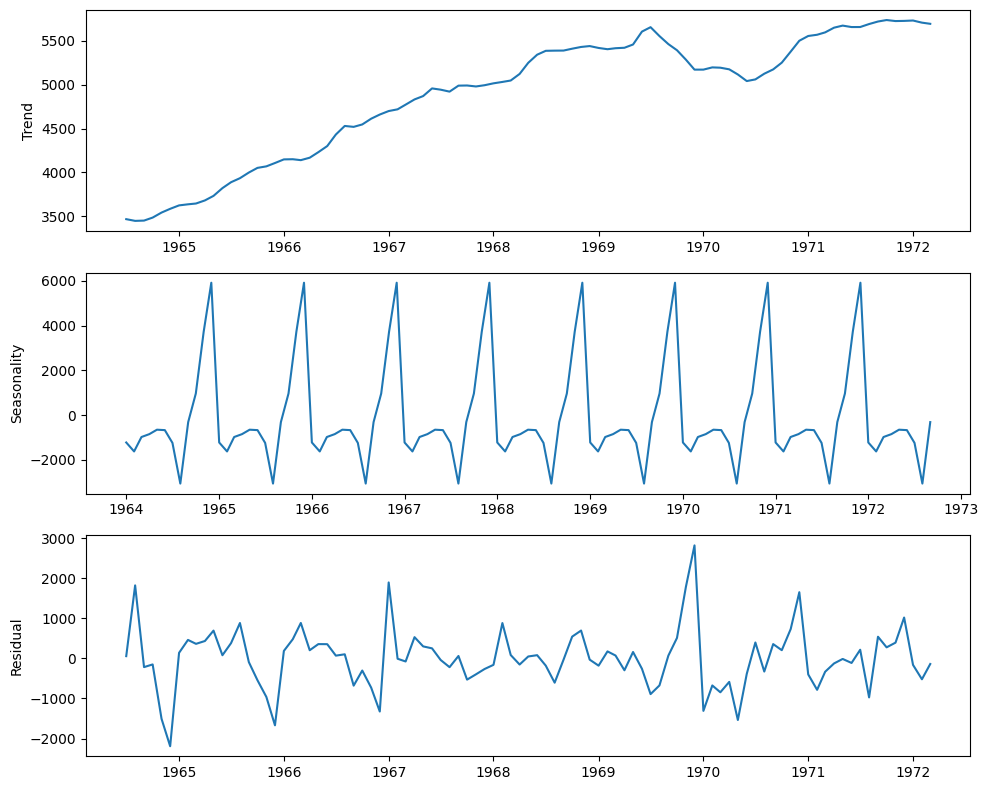

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

data = seasonal_decompose(sales)

plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(data.trend)
plt.ylabel('Trend')
plt.subplot(3,1,2)
plt.plot(data.seasonal)
plt.ylabel('Seasonality')
plt.subplot(3,1,3)
plt.plot(data.resid)
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

Key observations: <br> - There is a clear trend over time with a soft downtrend observed in late 1969. Overall, the trend flattens out in the outer years. <br> - Seasonality is evident. The data is on the scale of 3500 to 5500 and the seasonality varies from -2000 to 6000 which is quite significant. The peaks and troughs od the seasonality are not increasing over time but varying in a constant range, suggesting that the seasonality component is additive.

### ARIMA/SARIMA Model

ARIMA models use the historical data of a time series to make future predictions.



In ARIMA, the number of parameters depends on the order of the model. ARIMA models are denoted by three parameters: p, d, and q.

- p (AR): The autoregressive (AR) parameter represents the number of past observations included in the model. It indicates the number of past terms used to predict the current value of the time series based on its past values.
- d (I): The integrated (I) parameter is used in case the data is non stationary. It indicates the number of differences applied to the time series data to remove trends or seasonality.
- q (MA): The moving average (MA) parameter represents the size of the moving average window. It indicates the number of past forecast errors used to predict the current value of the time series.

Therefore, the total number of parameters in an ARIMA model is the sum of these three parameters: p + d + q.

Additionally, in seasonal ARIMA models known as SARIMA, there are additional seasonal parameters denoted as P, D, and Q denoting the autoregressive, differing, and moving average terms for the seasonal portion. So, the total number of parameters in a SARIMA model would be the sum of these six parameters: p + d + q + P + D + Q.

Back to our data set, there is seasonality in the series, so SARIMA (Seasonal ARIMA) will be used instead of ARIMA.


### Determine the optimum SARIMA parameters

There are few approaches to systematically determine the optimum parameters for our SARIMA model. In this excercise, we will the Grid Search approach to derive the parameters. We use the auto_arima function from pmd_arima library. The function will derive the parameter combination that returns the best AIC value.

In [ ]:
from pmdarima import auto_arima

parameters = auto_arima(sales['Actual'], seasonal = True, m = 12, start_p = 0, start_q = 0, max_P =10, max_D=10, max_Q =10)
parameters.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  105
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -745.083
Date:                             Sun, 05 May 2024   AIC                           1498.167
Time:                                     23:25:08   BIC                           1508.297
Sample:                                 01-01-1964   HQIC                          1502.257
                                      - 09-01-1972                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    362.8407    100.619      3.606      0.000     165.630     560.051
ma.L1          0.2191      0.074      2.970      0.003       0.075       0.364
ar.S.L12      -0.1784      0.082     -2.186      0.029      -0.338      -0.018
sigma2      5.135e+05   5.75e+04      8.924      0.000    4.01e+05    6.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 8.20
Prob(Q):                              0.55   Prob(JB):                         0.02
Heteroskedasticity (H):               1.27   Skew:                            -0.15
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here is the best parameter combination ARIMA(0,0,1) with seasonal adjusments (1,1,[],12). The number 12 represents that data is grouped by the month with seasonality happening every year.

### Fit and evaluate the SARIMA model

Let's split the data set to train and test sets. The last 20 months will be used as a test set and the remainder is used for training the model. 

In [ ]:

train_set = sales[:len(sales)-15]
test_set = sales[len(sales)-15:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train_set['Actual'], order = (0,0,1), seasonal_order = (1,1,[],12))
sarima_result = sarima_model.fit()


After the fit process is completed, we start with the estimation step. We use the predict function.

In [ ]:
prediction = sarima_result.predict( start = len(train_set), end =len(train_set)+ len(test_set) -1, typ= "levels")

sales['Prediction - SARIMA'] = prediction
sales.tail(20)

C:\Users\KateTran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,Actual,Prediction - SARIMA
Month,,
1971-02-01,3162.0,NaN
1971-03-01,4286.0,NaN
1971-04-01,4676.0,NaN
1971-05-01,5010.0,NaN
1971-06-01,4874.0,NaN
1971-07-01,4633.0,4265.644806
1971-08-01,1659.0,1743.930742
1971-09-01,5951.0,5221.071455
1971-10-01,6981.0,6456.011716


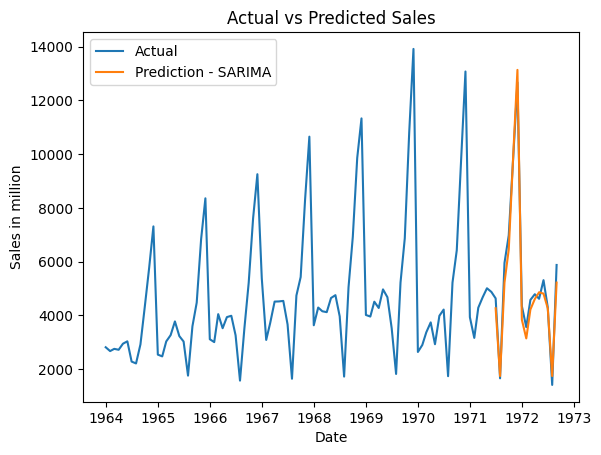

In [ ]:
plt.plot(sales)
plt.legend(sales.columns)
plt.xlabel('Date')
plt.ylabel('Sales in million')
plt.title('Actual vs Predicted Sales')
plt.show()

We are going to calculate Mean absolute error to evaluate accuracy of SARIMA predictions.

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

mae(test_set.Actual, prediction)/ test_set.Actual.mean()

0.06782265512933754

The result shows an error of 6.78% on average based on the test data, indicating that SARIMA model is a good fit.

### Forecast the future

Now, let's forecast the forecast champagne sales for the next 2 years using SARIMA model. To achieve this, we use the optimal model parameters to fit a model on the entire data set.

In [ ]:

sarima_model = SARIMAX(sales['Actual'], order = (0,0,1), seasonal_order = (1,1,[],12))
result = sarima_model.fit()

In [ ]:
new_dates = pd.date_range(start=sales.index[-1], periods=25, freq='MS')
forecast_months = pd.DataFrame(index=new_dates, columns= sales.columns)
forecast= pd.concat([sales,forecast_months[1:]])

C:\Users\KateTran\AppData\Local\Temp\ipykernel_16628\1039379399.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast= pd.concat([sales,forecast_months[1:]])


In [ ]:
forecast['Forecast'] = result.predict(start = len(forecast)-24, end = len(forecast), typ ='levels')
forecast.tail(30)

C:\Users\KateTran\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,Actual,Forecast
1972-04-01,4788.0,NaN
1972-05-01,4618.0,NaN
1972-06-01,5312.0,NaN
1972-07-01,4298.0,NaN
1972-08-01,1413.0,NaN
1972-09-01,5877.0,NaN
1972-10-01,NaN,6948.796184
1972-11-01,NaN,9850.464326
1972-12-01,NaN,12694.164860
1973-01-01,NaN,4323.358985


Now let's visualize the forecast data

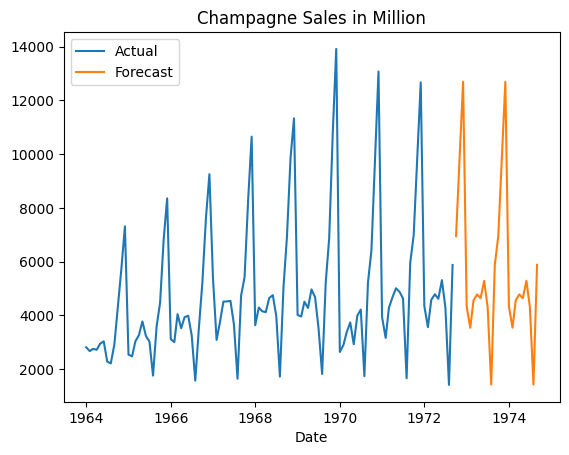

In [ ]:
plt.plot(forecast)
plt.legend(forecast.columns)
plt.xlabel('Date')
plt.title('Champagne Sales in Millions')
plt.show()